# Polynomial Regression as a Predictor of Cryptomarkets 

# Introduction

Financial systems in modern economies typically have a centralised structure, where various intermediaries such as banks, brokers, and exchanges are responsible for the core functions of the financial system. These intermediaries play a crucial role and are regulated by Central Banks to maintain monetary and fiscal stability.

This traditional architecture is currently going through somewhat of a revolution. Advancements in block-chain technology, have enabled an innovative new financial architecture to be developed - decentralised finance (DeFi) - "where record keeping is decentralised, access to the system is anonymous and unrestricted, and any form of intermediation would be built on top of it" (Makarov and Schoar, 2022, p.1)<sup>1</sup>.

## Business problem

DeFi runs on public blockchains - primarily the cryptocurrency Ethereum - to conduct regular financial services but in the digital space. DeFi is rapidly growing and complex to fully understand. The business problem this analysis will attempt to solve is:

_'To what extent is the price of Ethereum influenced by cryptomarkets versus changes to macroeconomic variables'._ 

# Data Cleaning

## BTC and ETH market data
The crypto market data used for this analysis will a time-series of price of Ethereum and Bitcoin (USD) and their respective volumes traded. In this section I read, clean and prepare Ethereum (ETH) and Bitcoin (BTC) market data.

In [1]:
import pandas as pd

In [142]:
## Read crypto data
btc = pd.read_csv('btc-price-data-output.csv')
eth = pd.read_csv('eth-price-data-output.csv')

## Add suffix to variables
btc = btc.add_suffix('-BTC')
eth = eth.add_suffix('-ETH')

## Rename variables
btc = btc.rename(columns = {'Unnamed: 0-BTC':'Day', 'CloseTime-BTC':'Date'})
eth = eth.rename(columns = {'Unnamed: 0-ETH':'Day', 'CloseTime-ETH':'Date'})

## Convert to datetime
btc['Date'] = pd.to_datetime(btc['Date'], format='%Y-%m-%d')
eth['Date'] = pd.to_datetime(eth['Date'], format='%Y-%m-%d')

## Merge crypto data
crypto_data = btc.merge(eth, on='Date', how='left')
crypto_data = crypto_data[['Date', 'HighPrice-BTC', 'HighPrice-ETH']]
crypto_data = crypto_data.rename(columns = {'HighPrice-ETH':'Price-ETH', 'HighPrice-BTC':'Price-BTC'})

crypto_data.head(3)

,Date,Price-BTC,Price-ETH
0,2020-01-01,7301.1,133.19
1,2020-01-02,7235.0,132.68
2,2020-01-03,7185.8,130.18


## Macroeconomic variables
The macroeconomic variables used for this analysis are listed below. In this section I will read, clean and prepare the macroeconomic variables:
* Unemployment rate
* Interest rate
* Inflation rate

In [143]:
## Read macroeconomic data
unemployment = pd.read_csv('uk-unemployment.csv')
interest = pd.read_csv('uk-interest-rate.csv')
inflation = pd.read_csv('uk-inflation.csv')

## Prepare macroeconomic variables
unemployment = unemployment.rename(columns = {'Title':'Date', 'Unemployment rate (aged 16 and over, seasonally adjusted): %':'UnemploymentRate'})
unemployment['Date'] = pd.to_datetime(unemployment['Date'], format='%Y %b')

interest = interest.rename(columns = {'Date Changed':'Date', 'Rate':'InterestRate'})
interest['Date'] = pd.to_datetime(interest['Date'], format='%d-%b-%y')
interest['Date'] = interest['Date'].dt.to_period('M').dt.to_timestamp()

inflation = inflation.rename(columns = {'Title':'Date', 'CPIH Annual Rate':'CPIH'})
inflation['Date'] = pd.to_datetime(inflation['Date'], format='%Y %b')
inflation.head()

## Join macroeconomic variables
unemp_interest = unemployment.merge(interest, on='Date', how='outer')
macro_data = unemp_interest.merge(inflation, on='Date', how='outer')

macro_data.head(3)

,Date,UnemploymentRate,InterestRate,CPIH
0,2020-01-01,4.0,0.75,1.8
1,2020-02-01,4.0,NaN,1.7
2,2020-03-01,4.1,0.10,1.5


## Finalise dataset
Merge crypto and macroeconomic dataframes to create a final dataframe ready for modelling.

In [144]:
## Merge crypto and macroeconomic datasets
data = crypto_data.merge(macro_data, on='Date', how='outer')

## Fill forward missing values - this is important for the macroeconomic variables that are monthly, not daily. 
data.fillna(method='ffill', inplace=True)

data.head(3)

,Date,Price-BTC,Price-ETH,UnemploymentRate,InterestRate,CPIH
0,2020-01-01,7301.1,133.19,4.0,0.75,1.8
1,2020-01-02,7235.0,132.68,4.0,0.75,1.8
2,2020-01-03,7185.8,130.18,4.0,0.75,1.8


# Exploratory Analysis

The price of Ethereum and Bitcoin can be plotted as a time series to first understand how these two variables change over time. This also gives an idea of the volatility of the variables.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


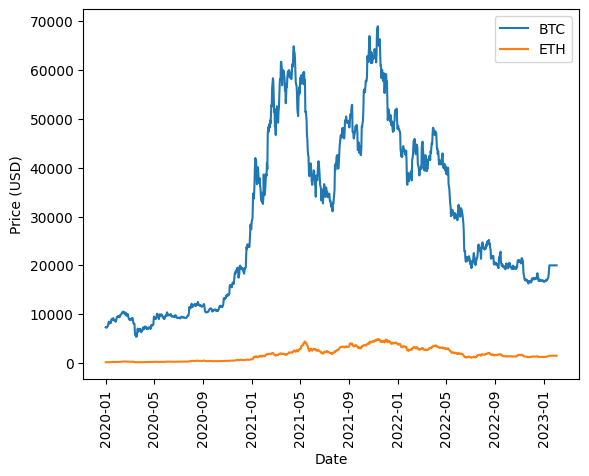

In [141]:
import matplotlib.pyplot as plt
plt.plot(data['Date'], data['Price-BTC'], label = 'BTC')
plt.plot(data['Date'], data['Price-ETH'], label = 'ETH')
plt.legend()
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Price (USD)')
plt.show()

A pairplot can be used to plot each of the variables in a dataframe against each other. This is a useful first step of exploratory analysis as it visualises all variables in single plot. Doing this allows us to get a *feel* for the data and to begin to identify trends and clusters. Distributions are visualised where variables are plotted against themselves. These help our understanding of the spread of the data within each variable.

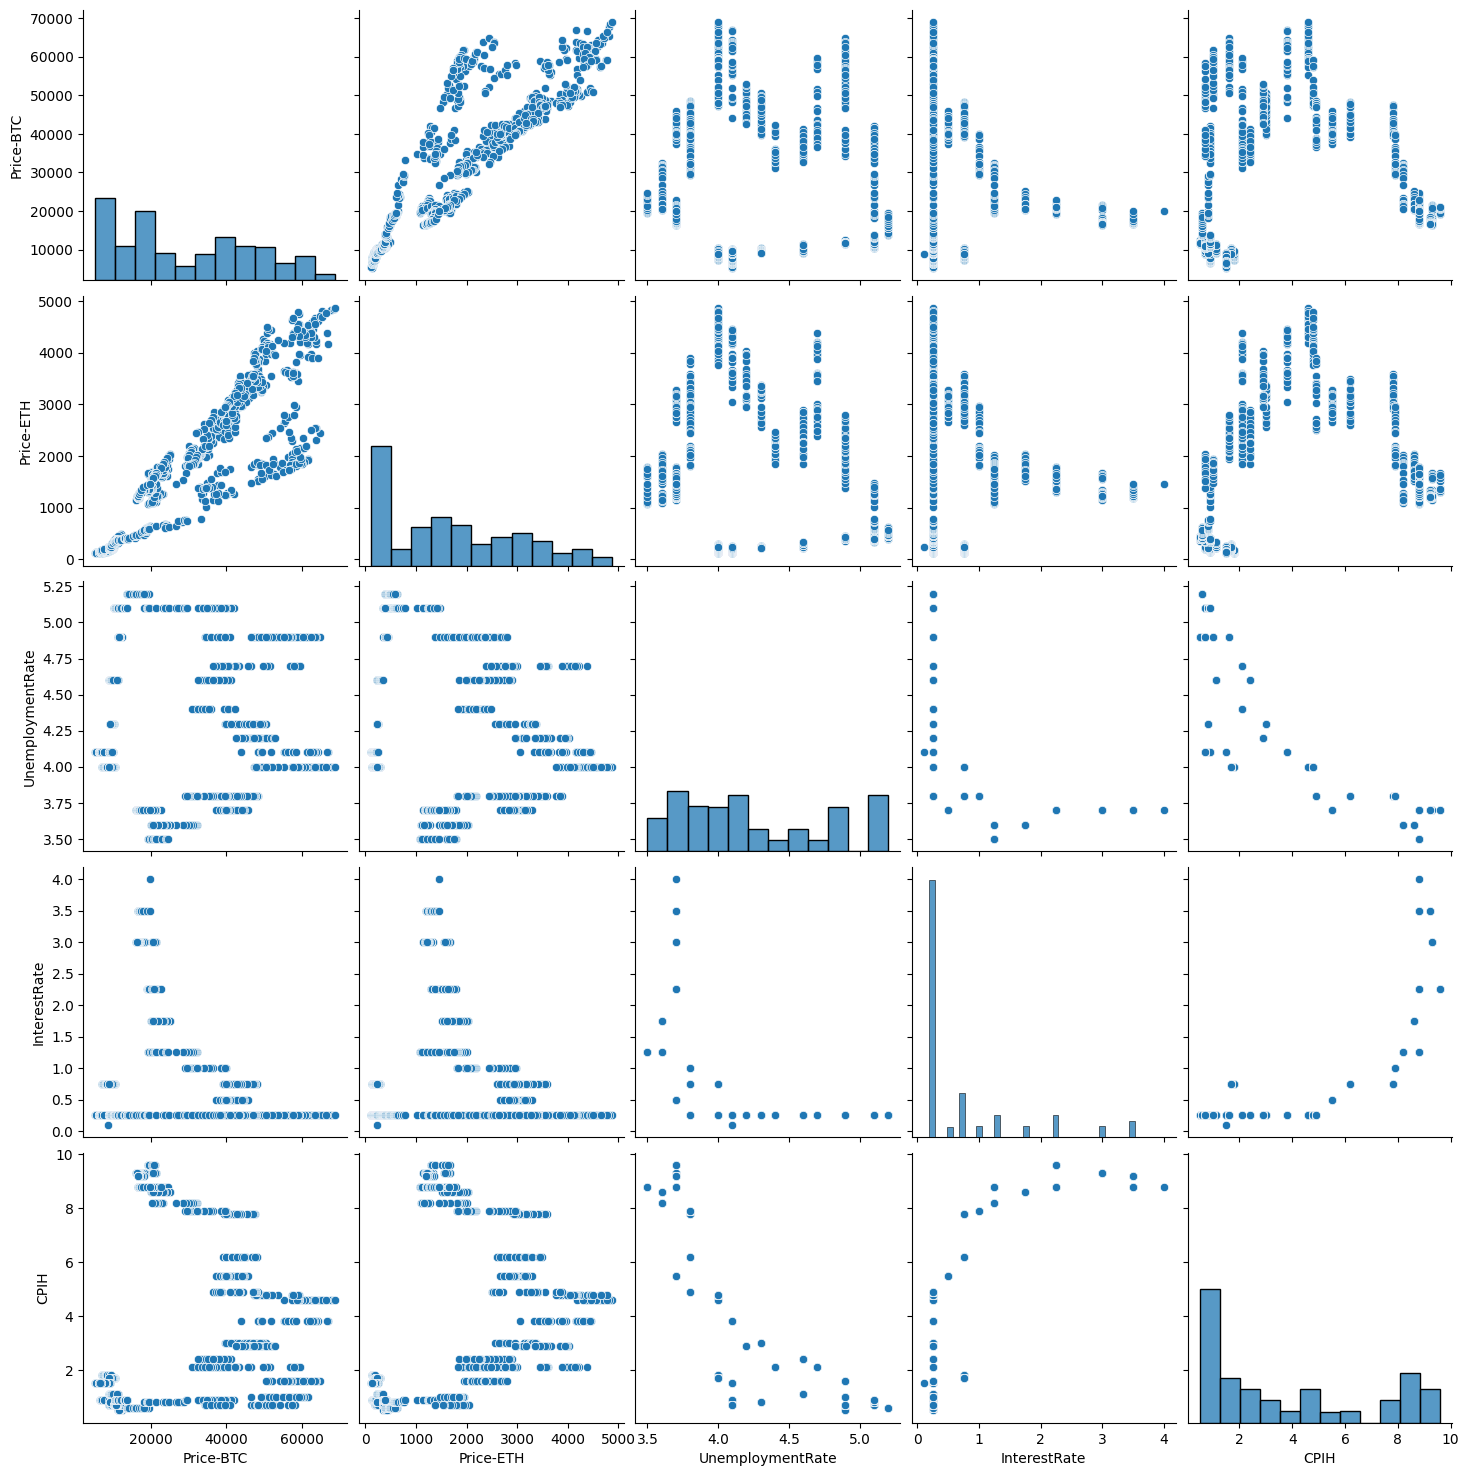

In [105]:
sns.pairplot(data, height=3)
plt.show()

The focus for this analysis is how the price of Ethereum is related to the other variables. 

The price of ETH seems somewhat positively correlated with the price of BTC. As one price has risen, so has the other. In contrast, there does not seemingly appear to be a relationship between the price of ETH and the volume of ETH nor BTC traded.

The price of ETH seems to fluctuate with changes to the macroeconomic variables but the relationship is not linear. This suggests a polynomial regression model may provide a better model fit for these variables.

Other notable aspects of the data are that the price of ETH is positively skewed - a large proportion of the values are clustered at the left tail of the distribution.

/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_1107/52847212.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap="YlGnBu", annot = True)


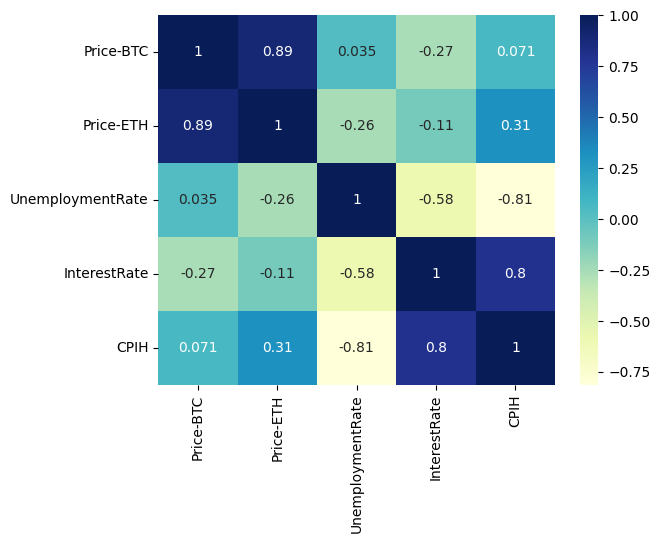

In [106]:
sns.heatmap(data.corr(), cmap="YlGnBu", annot = True)
plt.show()

This heatmap show the correlations between all pairs of variables in the dataframe. Values of 1 are perfectly correlated which unsuprisingly can be seen when the correaltions of variables on themselves are calculated. Positive and negative values indicate positive and negative correlation respectively. Values above 0.5 tend to be accepted as moderately correlated and 0.7 strongly correlated. The same is true for the negative values (-0.5, -0.7).

The price of ETH is strongly positively correlated to the price of BTC, with a correlation coefficient of 0.89. With respect to the macroeconomic variables, the price of ETH appears weakly correlated to both unemployment rate (negative correlation) and the inflation rate (CPIH). 

# Modelling

## Linear regression - price of BTC

A strong correlation between the price of ETH and BTC makes this a suitable candidate to model first.

R-squared:  0.819877844417242
Mean squared error:  320236.3824028409


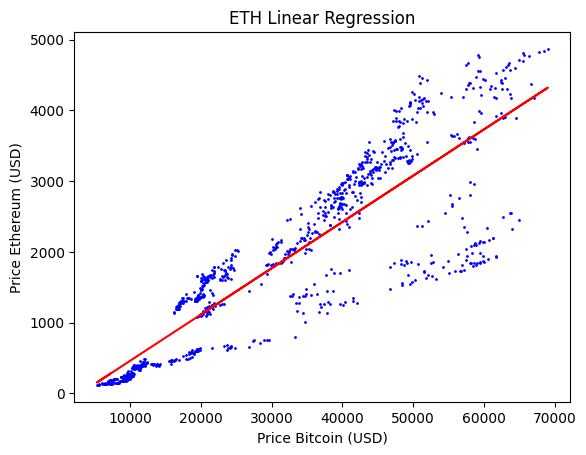

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Set feature and target variables
X = data[['Price-BTC']]
y = data[['Price-ETH']]

## Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
                                                    
## Create object of LinearRegression class
model = LinearRegression()

## Fit training data
model.fit(X_train,y_train)

## Run model
y_prediction =  model.predict(X_test)

## Predict accuracy score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np

print('R-squared: ', r2_score(y_test,y_prediction))
print('Mean squared error: ',mean_squared_error(y_test,y_prediction))

## Visualise
plt.scatter(X, y, color = 'b', s = 1)
plt.title('ETH Linear Regression')
plt.plot(X, model.predict(X), color = 'red')
plt.xlabel('Price Bitcoin (USD)')
plt.ylabel('Price Ethereum (USD)')
plt.show()

This model has a high R<sup>2</sup> score of 0.82 which suggests that the price of Bitcoin explains 82% of the avriance in the price of Ethereum. However, the model also has a high mean squared error (MSE), indicating that the model's predicted values have a high degree of variability or error compared to the actual values. Looking at the plot of the regression, it seems that the high MSE is capturing the noise in the data whilst the R<sup>2</sup> value is catching the overall positive trend.

## Polynomial regression - unemployment and inflation rate

To asses whether unemployment or inflation is a beter predictor of ETH price we can create a polynomial regression function which takes a variable as an argument. The model fit can then be compared between them. 

In [128]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def poly_regression(data, feature, target, degree, plot = False, plot_title = '', x_axis_label = '', y_axis_label = ''):
    
    ## Extract feature variables and target variable from dataframe
    X = data[feature]
    y = data[target]

    ## Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
        
    ## Create polynomial features
    poly_features = PolynomialFeatures(degree = degree)

    ## Create linear regression model
    linear_regression = LinearRegression()

    ## Create a pipeline that includes polynomial features and linear regression
    pipeline = make_pipeline(poly_features, linear_regression)

    ## Fit the pipeline to the data
    pipeline.fit(X_train, y_train)

    ## Predict target variable for new data
    y_prediction = pipeline.predict(X_test)

    ## Predict accuracy score
    print('R-squared: ', r2_score(y_test,y_prediction))
    print('Mean squared error: ', mean_squared_error(y_test,y_prediction))
    
    ## Visualise
    if plot == True:
        plt.scatter(X, y, color = 'b', s = 1)
        plt.title(plot_title)
        plt.plot(X, pipeline.predict(X), color = 'red')
        plt.xlabel(x_axis_label)
        plt.ylabel(y_axis_label)
        plt.show()

The degree of fit can be specified in the function defined above. For the below polynomial regressions these can be tweaked to find the most suitable fit. Whilst a high degree (8-10) does produce a good R<sup>2</sup> value, it is likely that the model is over-fitted. 

R-squared:  0.14595508917664546
Mean squared error:  1518393.1802657596


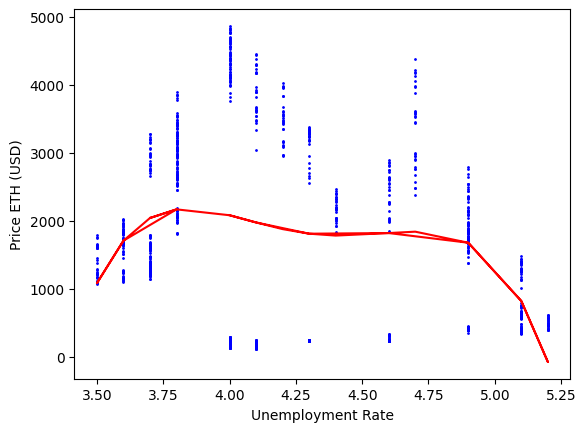

In [133]:
poly_regression(data = data, 
                feature = ['UnemploymentRate'], 
                target = 'Price-ETH', 
                degree = 4, 
                plot = True, x_axis_label = 'Unemployment Rate', y_axis_label = 'Price ETH (USD)')

R-squared:  0.6984916831482932
Mean squared error:  536046.9529168936


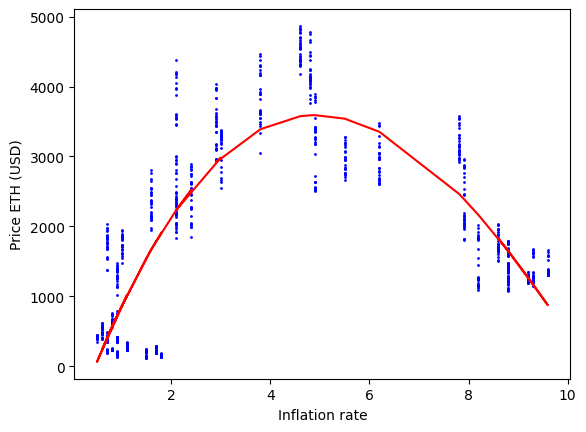

In [125]:
poly_regression(data = data, 
                feature = ['CPIH'], 
                target = 'Price-ETH', 
                degree = 3,
                plot = True, x_axis_label = 'Inflation rate', y_axis_label = 'Price ETH (USD)')

The model can also be fit using both unemployment and inflation rate as the feature variables. Since this can't be plotted without a third axis, we can use plot = False to ensure the model still runs.

In [ ]:
poly_regression(data = data, 
                feature = ['UnemploymentRate', 'CPIH'], 
                target = 'Price-ETH', 
                degree = 3,
                plot = False)

In [139]:
poly_regression(data = data, 
                feature = ['UnemploymentRate', 'CPIH', 'Price-BTC'], 
                target = 'Price-ETH', 
                degree = 3,
                plot = False)

R-squared:  0.9735536349830674
Mean squared error:  47018.58154721232


# Analysis


| # | Model | Feature variable(s) | R<sup>2</sup> | Mean squared error |
| :- | :- | :- | :- | :- |
| 1 | Linear regression | Price BTC | 0.820 | 320,236|
| 2 | Polynomial regression | Unemployment rate | 0.146 | 1,518,393 |
| 3 | Polynomial regression | Inflation rate | 0.698 | 536,046 | 
| 4 | Multi-polynomial regression | Unemp, Infl rate | 0.836 | 291,906 |
| 5 | Multi-polynomial regression | Price BTC, Unemp, Infl rate | 0.974 | 47,018 |

The table above summarises the model results from Section 4. The best model fit was achieved using model 5 - multi-polynomial regression with feature variables: price of Bitcoin, unemployment rate and inflation rate. These feature variables reportedly accounted for 97% of the variance in the predicted price of Ethereum. The mean squared error for this model, whilst still high, was by far the lowest of all the models. 

A high R<sup>2</sup> value and high mean squared error suggests that there is significant variance in the model but the general trend curve is well fit. This is particuallry evident looking at the plot of model 3 for inflation rate. The regression curve follows the trend of the data well but there is significant variance in the price of Ethereum for each inflation rate.   

The price of Bitcoin is also found to be the best single variable for predicting the price of Ethereum, with a higher R<sup>2</sup> value and low mean squared error than the other individual variable mdoel fits. However, a linear regression using the price of Bitcoin produced comparable results to a multi polynomial regression using both the unemployment and inflation rate. 

An interesting finding from the plot of model 3 is that the price of Ethereum peaks when the inflation rate is between 4-6%, with lower prices <4% and >6%. 

# Conclusion and Reflection

From this analysis, it is evident that there are a number of variables that should be considered when understanding the factors that influence the price of Ethereum. This study has identified that both market conditions (price of other crypto currencies) as well as macroeconomic variables, achieve a similar R<sup>2</sup> value when modelled as a regression, with similar mean squared errors. As a result, their ability to predict the price of Ethereum is comparable.

Upon reflection, one thing I have come to appreciate over the course of the Data Driven Analytis module is the importance of taking time and care in the data cleaning and preparation stage of the data science lifecycle. When approaching a data science problem I have found myself eager to get stuck into the analysis but the data preparation stage is crucial to producing accurate, meaningful analysis, and this takes time. In this analysis in particular, I found I underestimated the time that it would take to format each dataset in the same way such that they could be merged into a single dataframe for modelling. Working with time-series data brings with it some difficulties of working with date objects but having a good grasp of date formatting codes helped to ensure these were all formatted correctly.   

Another reflection I have had is how I specify a business problem. In my initial proposal I pitched this assignement as an 'exploratory analysis' of the Ethereum market, however, having taken on feedback provided in the course seminar it has become evident to me the importance of stating business problems in a way that can be solved using the data scinece lifecycle. As a result, I re-worded my problem to be more specific as well as meaasurable. In doing so I was able to form a conclusion in the analysis.

In evaluating how I would approach this assignment again in the future, there are a number of additions to the regression models that I would have liked to have implemented had I had more time. Given the time series data available, it would have been interesting to have created a lagged variable to understand how today's price of Ethereum is influenced by yesterday's price. The markets for crypto currencies are notably volatile so I would expect that a lagged indicator for Ethereum price would be less of a reliable indicator on today's price than for a stable currency (i.e. less reliable than predicting the value of the pound-sterling today based on yesterday's value).

Another addition I would have liked to have implemented was additional crypto market and macroeconomic variables. In this analysis I focussed on a select few, however these could have been expanded to other crypto currencies and other macroeconomic variables (e.g. GDP). I also limited the data used for the macroeconomic variables to the UK whereas a more universal measure, such as the average unemployment, inflation and interest rates across G7 countries, may have produced more accurate results. 

# References

<sup>1</sup> Makarov, I., Schoar, A. (2022) 'Cryptocurrencies and Decentralized Finance (DeFi)', _Brookings Papers on Economic Activity_, pp.141-215